# 13 Data Prep Part 2

> _"There are only two forces in the world, ~~the sword~~ dirty data and ~~the spirit~~ clean data. In the long run the ~~sword~~ dirty data will (not) always be conquered by the ~~spirit~~ clean data."_ ~ Napoleon CleanYourData

![Gathering Data](pictures/11.png)

## Outline for this Lesson

1. Data Cleaning Reminder
2. Cleaning 🐼
    - Dealing with Duplicates
    - Dealing with Missing Values
3. Saving our Cleaned Dataset
4. Test Your Understanding

## 1. Data Cleaning Reminder

Here is the data cleaning definition we saw earlier from a paper from Shaomin Wu titled, _"A Review on Coarse Warranty Data and Analysis"_ (see citation below).

> _"Data cleansing or data cleaning is the process of detecting and correcting (or removing) corrupt or inaccurate records from a record set, table, or database and refers to identifying incomplete, incorrect, inaccurate or irrelevant parts of the data and then replacing, modifying, or deleting the dirty or coarse data."_ ~ Wikipedia & Shaomin Wu

When we first encounter messy data, we usually start by going through a non-exhaustive checklist and/or use some rules of thumbs to identify, tackle, and repeat, each mess from the messy pile of data we have. Some of the items in our checklist might be:

- Do we have column names? If so,
- Are the column names normalised? (e.g. lower case, spaces or no spaces, numbers only as names)
- Do we have dates? If so,
    - how are these represented?
    - Do we have different formats in different rows? (e.g. 31-Oct-2020, October 31st 2020, ...)
    - Do they have the time in them or is this in a separate column?
- Are there different data structures within an element of an observation? (e.g. do we have lists with lists in them inside the value of a row and column combinantion)
- If we have numerical data points representing a monetary value, which denomination are these in?
- How was the data generated?
- Do we have any missing values? if so,
    - Are they missing at random?
    - Are they missing by accident? (e.g. was it due to an error during the data collection process)
    - Are they intentionally empty? (e.g. think of a conditional question in a survey, if the participant answered yes to the previous question, use this one next, if not, skip 3 questions)
- Are there any outliers in our dataset? if so,
    - Are these true outliers? (e.g. finding the salary of Jeff Bezos in a list with the income of all of the people from the state of Washington)
    - Are these mistakes? (e.g. finding negative prices for the price of bread)
- Are there any duplicate observations/samples in our dataset?
    
Remember, data cleaning is not a one time thing during the data analytics cycle but quite the opposite, you might find yourself going back to the data cleaning process 2 or more times as your understanding of the data increases during the same project.

**Source**  
Wu, Shaomin (2013) A Review on Coarse Warranty Data and Analysis. Reliability Engineering and System Safety, 114 . pp. 1-11. ISSN 0951-8320.

## 2. Cleaning

In [1]:
!pip install currencyconverter

In [2]:
import pandas as pd
import os
import numpy as np
from glob import glob
import urllib # we will use this again to get more websites
from PIL import Image # we will be looking at some Airbnb images
import requests
from io import BytesIO # for the images
from collections import defaultdict # takes one data type or structure by default
from currency_converter import CurrencyConverter 
from utilities import check_or_add # our previously created function

pd.options.display.max_columns = None
pd.options.display.max_rows = None

# this magic command helps us to not reload our session every time we install a new package

%load_ext autoreload

In [3]:
from utilities import check_or_add

We will add our data directory to a variable to make sure we always have it at our disposal.

**Note:** Make sure you change all of the forward slashes `/` into back slashes `\` if you are using Windows.

In [4]:
# path = '../data'

# uncomment this one if you have a windows computer
path = '../data'

Without even examining the data we can already expect to have files with different columns depending on when the scraping took place, and what kind of data was available at that time. Let's now have a look at the columns we have for one of the datasets for Belgium.

In [5]:
bel_path = check_or_add(path, 'belgium_data') # let's create a path variable for Belgium

In [6]:
df = pd.read_csv(os.path.join(bel_path, 'csv_files','belgium_1.csv')) # if this is not the same number as yours, pick another one
len(df.columns), df.columns

(106,
 Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
        'space', 'description', 'experiences_offered', 'neighborhood_overview',
        ...
        'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
        'require_guest_profile_picture', 'require_guest_phone_verification',
        'calculated_host_listings_count',
        'calculated_host_listings_count_entire_homes',
        'calculated_host_listings_count_private_rooms',
        'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
       dtype='object', length=106))

Wow! That's a of variables to play with and a lot of columns to go over. Let's now examine the first few rows of our file with the `.head()` method.

In [7]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,50904,https://www.airbnb.com/rooms/50904,20200622052900,2020-06-22,aplace/antwerp: cosy suite - fashion district,Decorated in a vintage style combined with a f...,Aplace Antwerp is located on a charming little...,Decorated in a vintage style combined with a f...,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/f14b0908-c...,NaN,234077,https://www.airbnb.com/users/show/234077,Karin,2010-09-14,"Antwerp, Flanders, Belgium",Since my childhoocd I dreamt of having my own ...,NaN,NaN,100%,f,https://a0.muscache.com/im/pictures/user/9cdb3...,https://a0.muscache.com/im/pictures/user/9cdb3...,NaN,4.0,4.0,"['email', 'phone', 'google', 'reviews', 'offli...",t,f,"Antwerp, Flanders, Belgium",NaN,Historisch Centrum,NaN,Antwerp,Flanders,2000.0,Antwerp,"Antwerp, Belgium",BE,Belgium,51.21858,4.39850,t,Boutique hotel,Hotel room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Paid parking off...",NaN,$145.00,NaN,NaN,$250.00,$25.00,1,$0.00,1,60,1,2,40,40,1.3,40.0,7 weeks ago,t,29,59,85,265,2020-06-22,1,0,2015-05-06,2015-05-06,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,4,2,0,0,0.02
1,116134,https://www.airbnb.com/rooms/116134,20200622052900,2020-06-22,Trendy Vacation Apartment Antwerp,Enjoy your stay at our 4 person apartment in t...,"You'll have the chance to stay in a very nice,...",Enjoy your stay at our 4 person apartment in t...,none,"The area ""`t eilandje"" is located at the old h...",Hou rekening met Lage Emissie Zone! meer info ...,NaN,As a guest you'll have access to all possible ...,We will be available to assist you with all qu...,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/23732573/0...,NaN,586942,https://www.airbnb.com/users/show/586942,Paul,2011-05-14,"Kapellen, Flemish Region, Belgium",My wife Gina and I will be glad to welcome you...,within an hour,100%,100%,t,https://a0.muscache.com/im/users/586942/profil...,https://a0.muscache.com/im/users/586942/profil...,NaN,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'selfie...",t,t,"Antwerp, Flemish Region, Belgium",NaN,Eilandje,NaN,Antwerp,Flemish Region,2000.0,Antwerp,"Antwerp, Belgium",BE,Belgium,51.23051,4.40593,t,Apartment,Entire home/apt,4,2.5,2.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Fr

Since we may not have the same variables for all datasets downloaded, we will create a function to loop over all datasets while extracting all columns from them.

In [8]:
def get_columns(data):
    df_cols = list(pd.read_csv(data, low_memory=False, encoding='utf-8').columns)
    return df_cols

We need all of our CSV files so we will grab them using the same `glob` method from before. Notice that we now have multiple `*` because we need to go through each country's CSV folder.

In [9]:
our_countries_data = glob(os.path.join(path, '*', 'csv_files', '*.csv'))
our_countries_data[:10]

['../data\\belgium_data\\csv_files\\belgium_0.csv',
 '../data\\belgium_data\\csv_files\\belgium_1.csv',
 '../data\\belgium_data\\csv_files\\belgium_2.csv',
 '../data\\belgium_data\\csv_files\\belgium_3.csv',
 '../data\\cape-town_data\\csv_files\\cape-town_4.csv',
 '../data\\cape-town_data\\csv_files\\cape-town_5.csv',
 '../data\\cape-town_data\\csv_files\\cape-town_6.csv',
 '../data\\cape-town_data\\csv_files\\cape-town_7.csv',
 '../data\\japan_data\\csv_files\\japan_10.csv',
 '../data\\japan_data\\csv_files\\japan_11.csv']

In [10]:
# let's have a look at how many files we have
len(our_countries_data)

12

We will now iterate over each of our files and append all of the columns to a list called `all_cols`.

In [11]:
%%time

all_cols = []

for file in our_countries_data:
    cols = get_columns(file)
    all_cols.append(cols)

Wall time: 9.26 s


In [12]:
all_cols[:2]

[['id',
  'listing_url',
  'scrape_id',
  'last_scraped',
  'name',
  'description',
  'neighborhood_overview',
  'picture_url',
  'host_id',
  'host_url',
  'host_name',
  'host_since',
  'host_location',
  'host_about',
  'host_response_time',
  'host_response_rate',
  'host_acceptance_rate',
  'host_is_superhost',
  'host_thumbnail_url',
  'host_picture_url',
  'host_neighbourhood',
  'host_listings_count',
  'host_total_listings_count',
  'host_verifications',
  'host_has_profile_pic',
  'host_identity_verified',
  'neighbourhood',
  'neighbourhood_cleansed',
  'neighbourhood_group_cleansed',
  'latitude',
  'longitude',
  'property_type',
  'room_type',
  'accommodates',
  'bathrooms',
  'bathrooms_text',
  'bedrooms',
  'beds',
  'amenities',
  'price',
  'minimum_nights',
  'maximum_nights',
  'minimum_minimum_nights',
  'maximum_minimum_nights',
  'minimum_maximum_nights',
  'maximum_maximum_nights',
  'minimum_nights_avg_ntm',
  'maximum_nights_avg_ntm',
  'calendar_updated',


Awesome! It only took essentially nothing to grab the columns of each file so we ended up saving ourselves a lot of time. Imagine how long it would have taken us to check the columns of every dataset 1 by 1?

![Can't imagine](https://media.giphy.com/media/3ohjV3KahwmqwPwQLu/giphy.gif)

## Exercise 1

1. Get the length of each list of columns and add it to a list. **Hint:** Try to mirror the step above.

2. Calculate the average amount of columns from such list.

In [13]:
%%time

all_nums = []

for cols in all_cols:
    nums = len(cols)
    all_nums.append(nums)


Wall time: 0 ns


In [14]:
all_nums

[74, 106, 106, 106, 74, 106, 106, 106, 106, 106, 74, 106]

In [15]:
%%time

np.mean(all_nums), all_nums

Wall time: 0 ns


(98.0, [74, 106, 106, 106, 74, 106, 106, 106, 106, 106, 74, 106])

Answers below! Don't peak 👀

In [16]:
# Answers
'''
%%time

all_nums = []

for cols in all_cols:
    nums = len(cols)
    all_nums.append(nums)'''

'\n%%time\n\nall_nums = []\n\nfor cols in all_cols:\n    nums = len(cols)\n    all_nums.append(nums)'

In [17]:
'''%%time

np.mean(all_nums), all_nums'''

'%%time\n\nnp.mean(all_nums), all_nums'

The next step we will take is to gather all of the columns in common in our data sample. To do this, we will first import the reduce function from the standard library called functools. We will then create an anonymous lambda function that takes a set `x` and a set `y` and then grabs the intersecting columns starting at `x` and reducing the set by all `y`s. This way, we will make sure we only grab the columns in common within all of our files.

In case you come back to this notebook later on and you want to try using different countries, you could convert the output of the previous cells we ran into a pandas dataframe and filter out the files without the specific amount of variables you need or want.

Here is an example of how to check whether any of the files we will use does not have 106 columns.

```python
temp = pd.DataFrame({'files':our_countries_data,
                     'columns':results,
                     'len': num_results})

temp.loc[temp['len'] != 106].head(50)
```

In [18]:
from functools import reduce

In [19]:
func = lambda x, y: set(x).intersection(set(y))

In [20]:
# This is the same as the above, the above is far cleaner

'''def a_func(x, y):
    temp_var = set(x).intersection(set(y))
    return temp_var
    '''

'def a_func(x, y):\n    temp_var = set(x).intersection(set(y))\n    return temp_var\n    '

Since the reduce function is lazy by default --meaning, no computation will take place until we tell it that we need the output-- we will wrap our reduce function in a list so that it returns the output immediately.

In [21]:
clean_cols = list(reduce(func, filter(None, all_cols)))
clean_cols[:5]

['minimum_nights_avg_ntm',
 'maximum_nights',
 'review_scores_checkin',
 'license',
 'last_scraped']

Let's check out how many columns we have in common in all of our files.

In [22]:
len(clean_cols)

72

Time to help ourselves even even further. Comma Separated Values tend to be quite messy, especially when they have multiple columns with many quotations marks and/or commas. When this happens, one or more can easily find its way into the wrong spot when we try to read in the data.

To start things off we will read in the data with all columns as strings (or python objects). The reason behind this is that you can already imagine that with columns with many valid elements such as dates, unique identifiers for purchases, etc., some are bound to miss the mark and thus be evaluated incorrectly. In essence, we will read everything in as a string and work our way through each column to fix or get rid of any of the many missing values we might have.

**Note:** for this example we will only use a dataset with 106 columns, if the one you chose at the beginning of the notebook has less than that, make sure you go back and read in one that does. If you are working on this notebook on your own, pick as many as you want! : )

In [23]:
# we will use a dictionary comprehension to assign the string type to each column in our clean_cols list
dtypes = {col:str for col in df.columns}
len(dtypes), dtypes

(106,
 {'id': str,
  'listing_url': str,
  'scrape_id': str,
  'last_scraped': str,
  'name': str,
  'summary': str,
  'space': str,
  'description': str,
  'experiences_offered': str,
  'neighborhood_overview': str,
  'notes': str,
  'transit': str,
  'access': str,
  'interaction': str,
  'house_rules': str,
  'thumbnail_url': str,
  'medium_url': str,
  'picture_url': str,
  'xl_picture_url': str,
  'host_id': str,
  'host_url': str,
  'host_name': str,
  'host_since': str,
  'host_location': str,
  'host_about': str,
  'host_response_time': str,
  'host_response_rate': str,
  'host_acceptance_rate': str,
  'host_is_superhost': str,
  'host_thumbnail_url': str,
  'host_picture_url': str,
  'host_neighbourhood': str,
  'host_listings_count': str,
  'host_total_listings_count': str,
  'host_verifications': str,
  'host_has_profile_pic': str,
  'host_identity_verified': str,
  'street': str,
  'neighbourhood': str,
  'neighbourhood_cleansed': str,
  'neighbourhood_group_cleansed': str,

We will now read in the data with have using only the files with 106 variables. Again, that is only for this example, use however many you like when working on your own.

In [24]:
%%time

our_dataframes = []

for data in our_countries_data: # all of our files
    
    if len(get_columns(data)) == 106: # we will only read in the ones with 106 variables
        df_temp = pd.read_csv(data, low_memory=False, dtype=dtypes, usecols=dtypes.keys()) # we will create a temporary dataframe for each
        our_dataframes.append(df_temp) # and append them all to a list
        
df = pd.concat(our_dataframes) # we will then concatenate them together to have one and only one dataframe
df.head() # show the data

Wall time: 14.7 s


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,50904,https://www.airbnb.com/rooms/50904,20200622052900,2020-06-22,aplace/antwerp: cosy suite - fashion district,Decorated in a vintage style combined with a f...,Aplace Antwerp is located on a charming little...,Decorated in a vintage style combined with a f...,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/f14b0908-c...,NaN,234077,https://www.airbnb.com/users/show/234077,Karin,2010-09-14,"Antwerp, Flanders, Belgium",Since my childhoocd I dreamt of having my own ...,NaN,NaN,100%,f,https://a0.muscache.com/im/pictures/user/9cdb3...,https://a0.muscache.com/im/pictures/user/9cdb3...,NaN,4.0,4.0,"['email', 'phone', 'google', 'reviews', 'offli...",t,f,"Antwerp, Flanders, Belgium",NaN,Historisch Centrum,NaN,Antwerp,Flanders,2000.0,Antwerp,"Antwerp, Belgium",BE,Belgium,51.218579999999996,4.3985,t,Boutique hotel,Hotel room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Paid parking off...",NaN,$145.00,NaN,NaN,$250.00,$25.00,1,$0.00,1,60,1,2,40,40,1.3,40.0,7 weeks ago,t,29,59,85,265,2020-06-22,1,0,2015-05-06,2015-05-06,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,4,2,0,0,0.02
1,116134,https://www.airbnb.com/rooms/116134,20200622052900,2020-06-22,Trendy Vacation Apartment Antwerp,Enjoy your stay at our 4 person apartment in t...,"You'll have the chance to stay in a very nice,...",Enjoy your stay at our 4 person apartment in t...,none,"The area ""`t eilandje"" is located at the old h...",Hou rekening met Lage Emissie Zone! meer info ...,NaN,As a guest you'll have access to all possible ...,We will be available to assist you with all qu...,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/23732573/0...,NaN,586942,https://www.airbnb.com/users/show/586942,Paul,2011-05-14,"Kapellen, Flemish Region, Belgium",My wife Gina and I will be glad to welcome you...,within an hour,100%,100%,t,https://a0.muscache.com/im/users/586942/profil...,https://a0.muscache.com/im/users/586942/profil...,NaN,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'selfie...",t,t,"Antwerp, Flemish Region, Belgium",NaN,Eilandje,NaN,Antwerp,Flemish Region,2000.0,Antwerp,"Antwerp, Belgium",BE,Belgium,51.230509999999995,4.405930000000001,t,Apartment,Entire home/apt,4,2.5,2.0,2.0,Real Bed,"{TV,""Cable TV

In [25]:
df.tail()


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
14710,43900698,https://www.airbnb.com/rooms/43900698,20200625032351,2020-06-25,"Ueno Cozy Apartment, 300m to station, free wifi",It's a private apartment on 2nd floor with 3 b...,Apartment layout: ***Bedroom*** -Bedroom 1: 2...,It's a private apartment on 2nd floor with 3 b...,none,NaN,NaN,NaN,NaN,NaN,No noise after 10pm. No shoes in the house.,NaN,NaN,https://a0.muscache.com/im/pictures/4b52842d-4...,NaN,130366873,https://www.airbnb.com/users/show/130366873,Jenny,2017-05-15,"Taitō, Tokyo, Japan",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/033d2...,https://a0.muscache.com/im/pictures/user/033d2...,NaN,0.0,0.0,"['email', 'phone', 'jumio', 'offline_governmen...",t,f,"Taito City, Tōkyō-to, Japan",Taito District,Taito Ku,NaN,Taito City,Tōkyō-to,110-0015,Tokyo,"Taito City, Japan",JP,Japan,35.71293,139.78014,t,Apartment,Entire home/apt,8,1.0,3.0,3.0,Real Bed,"{Wifi,""Air conditioning"",Kitchen,Heating,Washe...",NaN,"$40,025.00",NaN,NaN,$0.00,"$8,500.00",4,"$2,000.00",1,1125,1,1,1125,1125,1.0,1125.0,never,t,30,47,77,170,2020-06-25,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,M130004873,NaN,t,f,strict_14_with_grace_period,f,f,5,5,0,0,NaN
14711,43903348,https://www.airbnb.com/rooms/43903348,20200625032351,2020-06-25,✣新築✣ HOYOｽﾃｲ西巣鴨/固定wifi/駅徒歩5分/PCﾃﾞｽｸ/f,【HOYOｽﾃｲ西巣鴨 ｾﾐﾀﾞﾌﾞﾙﾀｲﾌﾟ】 ✣✣新築物件に黒を基調としたお部屋にはお布...,【お部屋】 ･寝室 ･ｷｯﾁﾝ ･風呂 ･ﾄｲﾚ ･洗面 【家具】 ･ｾﾐﾀﾞﾌﾞﾙﾍﾞｯﾄ...,【HOYOｽﾃｲ西巣鴨 ｾﾐﾀﾞﾌﾞﾙﾀｲﾌﾟ】 ✣✣新築物件に黒を基調としたお部屋にはお布...,none,【最寄駅】 都営地下鉄三田線西巣鴨駅まで徒歩5分 滝野川3丁目ﾊﾞｽ停まで徒歩4分 JR埼京...,NaN,【各地へのｱｸｾｽ/電車】 羽田空港…53分 成田空港…63分 浅草駅…49分(滝野川3丁目...,NaN,NaN,土足厳禁 21時以降の騒音厳禁,NaN,NaN,https://a0.muscache.com/im/pictures/9892460d-8...,NaN,198552582,https://www.airbnb.com/users/show/198552582,Masa,2018-06-28,"Tokyo, Japan",Thank you for seeing my profile.\r\nMy hobby i...,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/f5e21...,https://a0.muscache.com/im/pictures/user/f5e21...,Shinjuku District,76.0,76.0,"['email', 'phone', 'jumio', 'offline_governmen...",t,f,"Kita City, Tokyo, Japan",Kita District,Kita Ku,NaN,Kita City,Tokyo,114-0023,Tokyo,"Kita City, Japan",JP,Japan,35.745979999999996,139.72925,t,Apartment,Entire home/apt,2,1.0,1.0,NaN,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,Wa...",NaN,"$5,016.00",NaN,NaN,NaN,NaN,1,$0.00,2,1125,2,2

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124800 entries, 0 to 14714
Columns: 106 entries, id to reviews_per_month
dtypes: object(106)
memory usage: 101.9+ MB


## Let the Real Cleaning Begin

We now finally read in our data and can begin the cleaning process.


![Gathering Data](pictures/12.png)

Let's look at some of the information about our dataframes.

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124800 entries, 0 to 14714
Columns: 106 entries, id to reviews_per_month
dtypes: object(106)
memory usage: 101.9+ MB


## Dealing with Duplicates

Since we are expecting to have quite a few duplicates from the get go due to the scraping tool periodically grabing whatever listings are available in a country, we will tackle this at the very beginning. We will examine duplicates first using the `.duplicated()` function from pandas which will give us a boolean for the rows that have one or more copies of themselves in our dataframe.

In [28]:
%%time

dups = df.duplicated()
dups.sum()

Wall time: 1.42 s


0

Looks are deceiving and we certainly won't trust that there are no duplicated in our data. Let's examine our unique identifier columns to see whether we have a the same unique id for a host as the one applied by Inside Airbnb.

In [30]:
df[['id', 'host_id']].head()

,id,host_id
0,50904,234077
1,116134,586942
2,224333,1167377
3,224682,1263933
4,328911,1263814


We don't have matching id's so we will need to first confirm whether we have random `id`s or if they actually have something to do with the `host_id` in order to determine the best way for identifying, and getting rid of, duplicates.

We will use the `.groupby()` method to create a multi-index Series with `host_id` as the first level, `id` as the second, and the count of the name of the listings as our values.

In [31]:
%%time

id_frequency = df.groupby(['host_id', 'id'])['name'].count()
id_frequency

Wall time: 88.9 ms


host_id    id      
100002397  15542416    3
100011361  21320582    3
100023353  16165736    3
100028954  15545248    3
100036055  27237942    3
10004288   6002493     3
100043064  15546549    3
           20798499    3
100051151  15547787    3
100065460  20499850    3
10008751   1933826     3
100098226  16954388    3
           21721258    3
           31600636    1
100135656  15554778    3
100137931  15560536    3
100142728  15555686    3
           16129547    3
100162235  16563490    3
100167219  15558112    3
           15667201    3
100171921  27843599    3
100190815  15560161    3
1002081    37959588    3
100229369  15563210    3
100236447  15564597    3
           17571089    3
10025204   22140718    3
10026319   10604260    3
           10693965    3
100280744  38916900    3
100282493  15568640    3
10030211   39192420    3
1003126    34471290    3
100315114  40418602    2
           42952899    3
100330991  21497293    3
           21499429    3
100331034  40588032    3
10033

Indeed, it seems like we do have a lot of duplicated. But let's confirm this first by picking a random `host_id` and examining the dataframe with the `.head()` method.

In [32]:
df[df['host_id'] == '10026319'].head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
345,10604260,https://www.airbnb.com/rooms/10604260,20200622052900,2020-06-22,Historical City Antwerp.,The best place to stay if you like to be in th...,Our rooms are nice and spacious. You stay in a...,The best place to stay if you like to be in th...,none,In the middle of the historical city of Antwerp,Staying in our house you have to be able to cl...,Tram 10 and 11 from Central station stop in ou...,Beside your own room you can relax in the down...,We will be available to let you know where wha...,Respectful towards other guest and host!,NaN,NaN,https://a0.muscache.com/im/pictures/bb95f83e-3...,NaN,10026319,https://www.airbnb.com/users/show/10026319,Marc,2013-11-15,Belgium,"Hello,\r\n\r\nI was born in the Netherlands an...",within an hour,100%,75%,t,https://a0.muscache.com/im/users/10026319/prof...,https://a0.muscache.com/im/users/10026319/prof...,NaN,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Antwerpen, Vlaanderen, Belgium",NaN,Universiteitsbuurt,NaN,Antwerpen,Vlaanderen,2000.0,Antwerp,"Antwerpen, Belgium",BE,Belgium,51.22014,4.40545,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Kitchen,Breakfast,Heating,""S...",NaN,$60.00,$300.00,"$1,000.00",NaN,NaN,1,$20.00,1,1125,1,1,1125,1125,1.0,1125.0,4 months ago,t,30,60,90,365,2020-06-22,219,31,2016-01-25,2020-06-11,98.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,f,f,flexible,f,f,2,0,2,0,4.08
346,10693965,https://www.airbnb.com/rooms/10693965,20200622052900,2020-06-22,Antwerp center city,Our place is right in the heart of the histori...,It is situated in the center if the old town. ...,Our place is right in the heart of the histori...,none,The neighborhood is in the historical part of ...,NaN,The easiest is just to walk into the city ther...,You will enter the house through the Downstair...,I will be present to help you out with any kin...,Respect to other guests and host! And keep the...,NaN,NaN,https://a0.muscache.com/im/pictures/7f1451c9-c...,NaN,10026319,https://www.airbnb.com/users/show/10026319,Marc,2013-11-15,Belgium,"Hello,\r\n\r\nI was born in the Netherlands an...",within an hour,100%,75%,t,https://a0.muscache.com/im/users/10026319/prof...,https://a0.muscache.com/im/users/10026319/prof...,NaN,2.0,2.0,"['email', 'phone', 'facebook', 'r

As we can see, `host_id` represents a unique value assigned to the host of a listing regardless of how many that same host has available. In contrast, the `id` variable belongs to the unique listing.

Armed with this knowledge we can come up with two ways of dealing with the duplicate values.

1. We can use the combination of `host_id` and `name` (shown below), sort by the `last_scraped` variable to keep the latest one, and drop the duplicates, **or**  
2. We can use the `id` var (shown below), sort by the `last_scraped` variable to keep the latest one, and drop the duplicates.

In [33]:
# option 1
df.loc[(df['host_id'] == '10026319') & 
        (df['name'] == 'Historical City Antwerp.'), ['name', 'last_scraped']].head(10)

,name,last_scraped
345,Historical City Antwerp.,2020-06-22
353,Historical City Antwerp.,2020-05-27
358,Historical City Antwerp.,2020-04-28


In [34]:
# option 2
df.loc[df['id'] == '10604260', ['name', 'last_scraped']].head()

,name,last_scraped
345,Historical City Antwerp.,2020-06-22
353,Historical City Antwerp.,2020-05-27
358,Historical City Antwerp.,2020-04-28


We will use the combination of the `host_id` and `name` variables in our drop duplicates call so let's examine first how many duplicates we have.

In [35]:
len(df)

124800

In [38]:
%%time

dups = df[['host_id', 'name']].duplicated()
dups.sum()

Wall time: 54.4 ms


81310

In [39]:
_ / df.shape[0] * 100

# The underscore uses the very last cell output number, in this case cell above turned into a percentage, 65% of dataframe is duplicates

65.15224358974359

It seems like we do have quite a few duplicates. Now that we have a good plan in place, let's create a function to deal with the duplicates and pass our dataframe through it.

In [40]:
def get_rid_of_duplicates(data, sort_by_col, id_cols):
    """
    This function takes in a pandas dataframe, sorts it by a given column, and drops
    the duplicate rows given a unique column(s)
    """
    data1 = data.sort_values(by=sort_by_col, ascending=False) # Default is ascending, by passing the argument false we can make the data sort by decending
    data2 = data1.drop_duplicates(subset=id_cols)
    
    return data2

In [41]:
%%time

# notice that we create another dataframe with a cleaner version
df1 = get_rid_of_duplicates(df, sort_by_col='last_scraped', id_cols=['host_id', 'name'])

Wall time: 822 ms


In [42]:
df1.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43490 entries, 5866 to 16149
Columns: 106 entries, id to reviews_per_month
dtypes: object(106)
memory usage: 466.1 MB


In [43]:
dups = df1[['host_id', 'name']].duplicated()
dups.sum()

0

Awesome, we now have a deduplicated dataset in our hands.

If we get curious enough along we can use the following function to display a few of the images avaliable per listing. Let's try it out.

In [44]:
def image_show(image_url):
    return Image.open(BytesIO(requests.get(image_url).content))

In [45]:
images = df1.loc[df1['picture_url'].notnull(), 'picture_url'] #notnull() is a boolean true false condition, only shows ones that have values
images.tail()

15965    https://a0.muscache.com/im/pictures/cd0617dd-5...
16209    https://a0.muscache.com/im/pictures/f5df4a21-c...
16069    https://a0.muscache.com/im/pictures/c244a25e-6...
16146    https://a0.muscache.com/im/pictures/7ada1fee-8...
16149    https://a0.muscache.com/im/pictures/4d126929-f...
Name: picture_url, dtype: object

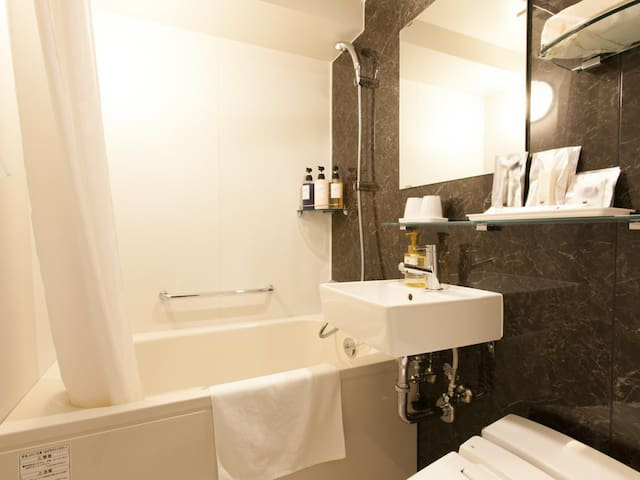

In [46]:
image_show(images.iloc[12602])

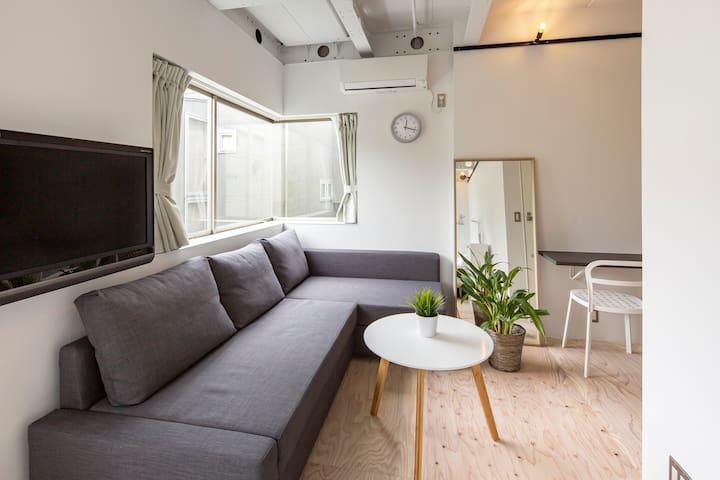

In [47]:
image_show(images.iloc[11214])

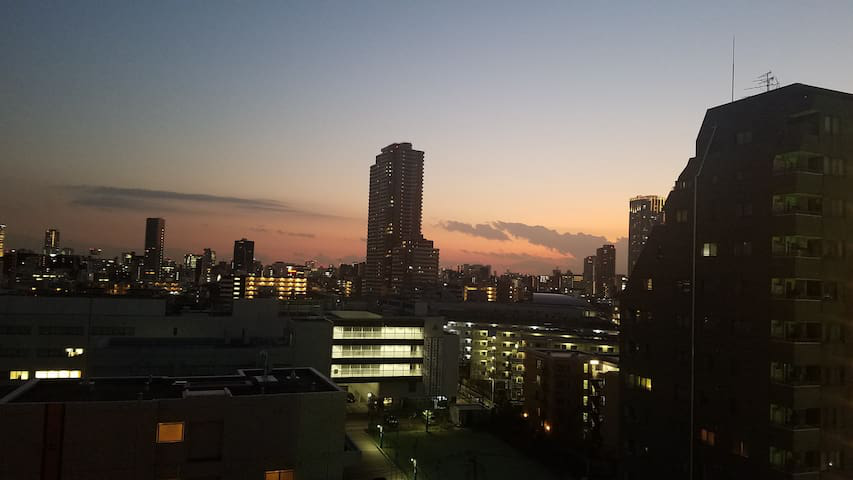

In [48]:
image_show(images.iloc[12848])

Let's now deal with any missing values.

## Dealing with Missing Values

In [49]:
%%time

# Get the raw count of missing values in all columns
missing_values = df1.isna().sum()

# Divide it by the total size of the dataset and multiply by 100 to get the % of the total
missing_pct = ((missing_values / df1.shape[0]) * 100)
missing_pct

Wall time: 281 ms


id                                                0.000000
listing_url                                       0.000000
scrape_id                                         0.000000
last_scraped                                      0.000000
name                                              0.004599
summary                                           2.306277
space                                            21.890090
description                                       1.621062
experiences_offered                               0.000000
neighborhood_overview                            26.564728
notes                                            45.325362
transit                                          26.599218
access                                           37.997241
interaction                                      33.304208
house_rules                                      47.020005
thumbnail_url                                   100.000000
medium_url                                      100.0000

We will start by selecting a few thresholds.

- For columns that have less than or equal to 5% of their values missing, we will drop these rows.
- For columns that have an amount of missing values between 5% exclusive, and 50% exclusive, we will explore different ways fix these.
- For columns that have an amount of missing values greater than or equal to 50%, we will drop these columns.

Notice that our missing_count_pct is a pandas series and the column names of our dataframe represent the index of our series. This means that we can create a mask with a percentage condition, and use the `.index` attribute from pandas to select the names of the columns.

In [50]:
rows_to_drop = list(missing_pct[(missing_pct <= 5) & (missing_pct > 0)].index)
rows_to_drop[:10]

['name',
 'summary',
 'description',
 'host_name',
 'host_since',
 'host_location',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_listings_count']

In [51]:
print(f'We will be dropping rows from {len(rows_to_drop)} columns that have less than 5% of observations missing. Wow!')

We will be dropping rows from 20 columns that have less than 5% of observations missing. Wow!


In [52]:
df2 = df1.dropna(subset=rows_to_drop)

## Exercise 2

1. Create a list of the columns to drop. These columns should have more than or equal to 50% of missing values. Name this variable `cols_to_drop`.

2. Create a list of columns to fix. These columns should have between 5% and 50% of missing values (exclusive of these two numbers). Name this new variable `fix_these_columns`.

In [53]:
cols_to_drop = list(missing_pct[(missing_pct >= 50)].index)
cols_to_drop[:10]

['thumbnail_url',
 'medium_url',
 'xl_picture_url',
 'host_neighbourhood',
 'neighbourhood',
 'neighbourhood_group_cleansed',
 'square_feet',
 'weekly_price',
 'monthly_price',
 'license']

In [55]:
cols_to_fix = list(missing_pct[(missing_pct < 50) & (missing_pct > 5)].index)
cols_to_fix[:10]

['space',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'host_about',
 'host_response_time',
 'host_response_rate']

Answers below! Don't cheat 👀

In [ ]:
cols_to_drop = list(missing_pct[(missing_pct >= 50)].index)
cols_to_drop

In [ ]:
fix_these_columns = list(missing_pct[(missing_pct > 5) & (missing_pct < 50)].index)
fix_these_columns

Now, let's go ahead and remove the columns we would like to drop since they have more than half of their values missing. **Note** that you should always be careful with the threshold you pick to drop missing values and document everything that you do with the data. It is also useful to check in with stakeholders to deal with these more effectively.

In [56]:
df2 = df2.drop(cols_to_drop, axis=1)

In [58]:
df2[cols_to_drop].head() # Should error because we removed the cols to drop

KeyError: "None of [Index(['thumbnail_url', 'medium_url', 'xl_picture_url', 'host_neighbourhood',\n       'neighbourhood', 'neighbourhood_group_cleansed', 'square_feet',\n       'weekly_price', 'monthly_price', 'license', 'jurisdiction_names'],\n      dtype='object')] are in the [columns]"

By passing the `fix_these_columns` list to our dataframe and calling the `.head()` method we can evaluate the data types available in each of the columns that are left to clean.

In [60]:
df2[cols_to_fix].head()


,space,neighborhood_overview,notes,transit,access,interaction,house_rules,host_about,host_response_time,host_response_rate,host_acceptance_rate,security_deposit,cleaning_fee,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
5866,"Three-storey building, four rooms: The first f...",Shin-Okubo Station is famous for its Korean ci...,Basically check in time at 16:00 / check out t...,"◎ There are two nearest stations, namely Shin-...","The new decoration and equipment, we hope you ...",Any problem in Tokyo can provide assistance du...,NaN,NaN,within an hour,100%,100%,"$21,437.00","$8,575.00",2019-02-26,2020-03-11,91.0,10.0,9.0,9.0,9.0,10.0,9.0,1.17
13341,It is located a 7-minute walk from Higashi-Shi...,The best thing of my place is the accessibilit...,EASY Check-in and Checkout: Happy to be flexib...,Higashi Shinjuku station - 7mins on foot. JR S...,You will have full kitchen with everything you...,I am more than willing to help you out if you ...,NaN,"Hello, guys! My name is Emily. \r\nI love to t...",within an hour,99%,100%,$0.00,"$10,000.00",2020-04-03,2020-04-30,100.0,8.0,10.0,8.0,9.0,8.0,10.0,0.71
3738,◆My house is a new building 7 min. Walk from M...,My house is a 7-minute walk from Minami-Senju ...,"After confirming the reservation, I will send ...",Tokyo Metro Hibiya Line / Minami-Senju Station...,All rooms are free to use.,"I am not staying at this house. However, if th...",NaN,NaN,within an hour,100%,100%,$0.00,"$6,600.00",2018-07-27,2020-05-31,97.0,10.0,10.0,10.0,10.0,9.0,10.0,2.4
2346,"東京の朝倉彫塑館､ﾌｧｰﾌﾞﾙ昆虫館､幸田露伴住宅｢蝸牛庵｣の近くに位置にあります,無料Wi...","It’s closed to ueno,ikebukuro,Tokyo station,ak...","Keep room ,shower room,toilet clean,walk slowl...","There are 3 train stations nearby my house, 1 ...","This is old long history street, it’s call yan...",I am so glad to help you travel to Tokyo and a...,NaN,"我是Linlin,喜欢旅游,深深地体会着住宿在旅游中是个大消费,所以我愿意提供一个干净,便宜...",within an hour,100%,96%,"$30,000.00","$4,500.00",2017-11-25,2020-02-18,91.0,9.0,9.0,10.0,10.0,10.0,9.0,1.94
13189,-a double sized bed - TV - Tabel - two Chairs...,NaN,Since the new law has come into effect from Ju...,"The nearest station is JR Yamanote Line ""Komag...",Entire apartment is yours:),Please contact me via Airbnb messaging if you ...,NaN,Hello\r\nMy name is Hirofumi Masuda.\r\nI had ...,within an hour,100%,100%,"$50,000.00","$3,000.00",2020-03-04,2020-05-11,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1.04


Since we don't know the real reason for the missing values in the non-numerical colums, (for example, transit might be empty because the location is geniuinly away from any trafic whatsoever or the house might have no strict rules at all 🤷🏻) we will select these columns manually, add them to a list, and fill in any missing values using the word `"Unknown"`. We will create this mapping of column names with the word `"Unknown"` using the help of a dictionary comprehension again and pass it to the dask dataframe method called `.fillna()`.

In [61]:
non_numerical_vars = ['space', 'neighborhood_overview', 'notes', 'transit', 'access',
                      'interaction', 'house_rules', 'host_about', 'host_response_time']

In [62]:
unknown_condition = {col:'Unknown' for col in non_numerical_vars}
unknown_condition

{'space': 'Unknown',
 'neighborhood_overview': 'Unknown',
 'notes': 'Unknown',
 'transit': 'Unknown',
 'access': 'Unknown',
 'interaction': 'Unknown',
 'house_rules': 'Unknown',
 'host_about': 'Unknown',
 'host_response_time': 'Unknown'}

In [63]:
df2 = df2.fillna(unknown_condition)

Let's get the rest of the variables we need to fix by taking the set difference between the `non_numerical_vars` list and the `fix_these_columns` list.

In [65]:
set_of_cols_left = set(cols_to_fix).difference(set(non_numerical_vars))
set_of_cols_left

{'cleaning_fee',
 'first_review',
 'host_acceptance_rate',
 'host_response_rate',
 'last_review',
 'review_scores_accuracy',
 'review_scores_checkin',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_rating',
 'review_scores_value',
 'reviews_per_month',
 'security_deposit'}

## Missing Dates

The missing observations we have might be due to the the hosts not having a review at all to showcase. In order to prove this, we will create a mask based on boolean conditions and check whether the missing values in `first_review` and `last_review` have any reviews at all.

In [67]:
df2.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
5866,31000095,https://www.airbnb.com/rooms/31000095,20200625032351,2020-06-26,Shinjuku JR Shin-okubo sta. 3mins Homely House,"The district Shinjuku area,nearby JR Shin-okub...","Three-storey building, four rooms: The first f...","The district Shinjuku area,nearby JR Shin-okub...",none,Shin-Okubo Station is famous for its Korean ci...,Basically check in time at 16:00 / check out t...,"◎ There are two nearest stations, namely Shin-...","The new decoration and equipment, we hope you ...",Any problem in Tokyo can provide assistance du...,Unknown,https://a0.muscache.com/im/pictures/92e9a30d-a...,23641660,https://www.airbnb.com/users/show/23641660,Airi,2014-11-12,"Toshima, Tokyo, Japan",Unknown,within an hour,100%,100%,f,https://a0.muscache.com/im/users/23641660/prof...,https://a0.muscache.com/im/users/23641660/prof...,12.0,12.0,"['email', 'phone', 'jumio', 'selfie', 'governm...",t,f,"Shinjuku, Tokyo, Japan",Shinjuku Ku,Shinjuku,Tokyo,169-0073,Tokyo,"Shinjuku, Japan",JP,Japan,35.6991,139.69794,t,House,Entire home/apt,11,2.0,4.0,7.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,Wa...","$63,026.00","$21,437.00","$8,575.00",2,"$2,144.00",2,1125,2,2,1125,1125,2.0,1125.0,3 months ago,t,26,46,63,149,2020-06-26,19,13,2019-02-26,2020-03-11,91.0,10.0,9.0,9.0,9.0,10.0,9.0,t,t,f,flexible,f,f,2,2,0,0,1.17
13341,42388049,https://www.airbnb.com/rooms/42388049,20200625032351,2020-06-26,MUMU) Tokyo's premier center Shinjuku! Free WIFI,** Discount for May&June! ** Duplex Apartment ...,It is located a 7-minute walk from Higashi-Shi...,** Discount for May&June! ** Duplex Apartment ...,none,The best thing of my place is the accessibilit...,EASY Check-in and Checkout: Happy to be flexib...,Higashi Shinjuku station - 7mins on foot. JR S...,You will have full kitchen with everything you...,I am more than willing to help you out if you ...,Unknown,https://a0.muscache.com/im/pictures/c5606851-1...,30451776,https://www.airbnb.com/users/show/30451776,Emily,2015-04-02,Tokyo、日本,"Hello, guys! My name is Emily. \r\nI love to t...",within an hour,99%,100%,f,https://a0.muscache.com/im/pictures/user/6ab9c...,https://a0.muscache.com/im/pictures/user/6ab9c...,24.0,24.0,"['email', 'phone', 'manual_offline', 'offline_...",t,f,"Shinjuku City, Tōkyō-to, Japan",Shinjuku Ku,Shinjuku City,Tōkyō-to,160-0022,Tokyo,"Shinjuku City, Japan",JP,Japan,35.70109,139.71163,t,House,Entire home/apt,7,1.0,3.0,1.0,Real Bed,"{TV,Wifi,""Air co

In [69]:
# We want to confirm that the amount of missing number of reviews values is related to the first and last review having no date

time_mask = ((df2['first_review'].isnull()) & (df2['last_review'].isnull()))

testing = df2.loc[time_mask, ['first_review', 'last_review', 'number_of_reviews']]
testing.head(20)

,first_review,last_review,number_of_reviews
13219,NaN,NaN,0
13228,NaN,NaN,0
13230,NaN,NaN,0
11332,NaN,NaN,0
11333,NaN,NaN,0
6144,NaN,NaN,0
13244,NaN,NaN,0
13252,NaN,NaN,0
11363,NaN,NaN,0
8016,NaN,NaN,0


In [70]:
# Converting to int to be able to do a mathmatic calculation on it
testing['number_of_reviews'].astype(np.int32).sum()

0

Since we have no reviews for the first and last review columns, we will fill in the missing values with the date in the `host_since` variable. This will help us identify that there have been 0 days, months, and years since the first and last review for that listing.

In [71]:
# let's create our two conditions
first_review_condition = df2['first_review'].isnull()
last_review_condition = df2['last_review'].isnull()

In [72]:
# Where function takes a boolean, where something is true I want you to do something else.
# Tilda reverses the where so that where is NaN (FALSE), fill it up with something. 
# we will then create two variables and use the where method to fill in the missing data with
# the date the host joined Airbnb

first_review = df2['first_review'].where(~first_review_condition, df2['host_since'])
last_review = df2['last_review'].where(~last_review_condition, df2['host_since'])

The `.where()` method takes a boolean array and fills in the False evaluations with whatever value we provide as a second argument. In our case, the `host_since` date.

We will now drop the original columns and reassign the new ones without any missing values to the dataframe.

In [73]:
df3 = (df2.drop(['first_review', 'last_review'], axis=1)
              .assign(first_review=first_review, last_review=last_review))

In [74]:
# notice that there are no more missing values
df3.loc[df3['first_review'].isnull(), ['first_review', 'last_review', 'host_since']].head()

,first_review,last_review,host_since


In [75]:
# let's evaluate the set of cols we have left
set_of_cols_left

{'cleaning_fee',
 'first_review',
 'host_acceptance_rate',
 'host_response_rate',
 'last_review',
 'review_scores_accuracy',
 'review_scores_checkin',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_rating',
 'review_scores_value',
 'reviews_per_month',
 'security_deposit'}

In [76]:
# since we just fixed the dates, we will remove them from our set
set_of_cols_left.remove('first_review')
set_of_cols_left.remove('last_review')

Let's examine the values of what we have left to clean.

In [77]:
df3[list(set_of_cols_left)].head()

,review_scores_communication,review_scores_checkin,review_scores_location,review_scores_value,review_scores_cleanliness,review_scores_accuracy,cleaning_fee,reviews_per_month,host_acceptance_rate,security_deposit,host_response_rate,review_scores_rating
5866,9.0,9.0,10.0,9.0,9.0,10.0,"$8,575.00",1.17,100%,"$21,437.00",100%,91.0
13341,9.0,8.0,8.0,10.0,10.0,8.0,"$10,000.00",0.71,100%,$0.00,99%,100.0
3738,10.0,10.0,9.0,10.0,10.0,10.0,"$6,600.00",2.4,100%,$0.00,100%,97.0
2346,10.0,10.0,10.0,9.0,9.0,9.0,"$4,500.00",1.94,96%,"$30,000.00",100%,91.0
13189,10.0,10.0,10.0,10.0,10.0,10.0,"$3,000.00",1.04,100%,"$50,000.00",100%,100.0


## Recoding Data

Sometimes we do have to take care of things manually so we will start by dealing with all of the columns that have a currency sign in them regardless if they have missing values or not. Because we only want the digits and the dots, we will import `digits` from the string module of Python and add to it the `.` dot.

In [78]:
from string import digits
digits += '.'
digits

'0123456789.'

For our cleaning currency function, we will pass in a value from a column, check whether it is a string or something else, and strip out anything that is not a number or a `.`dot.

In [79]:
def remove_puncs(string_piece):
    if string_piece:
        string = str(string_piece).strip()
        clean_str = ''.join([num for num in string if num in digits])
        return clean_str
    else:
        return np.nan

Since we should always test our functions, let's make sure it does return the currencies in the way we need them.

In [80]:
examples = [np.nan, '〒1690072', '%%7.0', '0.5%', 'nan', '$39.0', '$23.56']

test_examples = [remove_puncs(s) for s in examples]
test_examples

['', '1690072', '7.0', '0.5', '', '39.0', '23.56']

We can also check that the values can be converted into floats without any issues.

In [81]:
# Things that evaluate to nothing:

# None, np.nan, '', [], {}, 

In [82]:
del df
del df1

In [83]:
for i in list(filter(None, test_examples)):
    print(float(i))

1690072.0
7.0
0.5
39.0
23.56


Using the `deafaultdict` method from the collections module, we will iterate over our numerical columns while cleaning the numbers up a bit. We will convert the values into `float32` type and make sure any kind of numeric value gets converted into a numerical value with `pd.to_numeric()`.

In [84]:
%%time

strip_type_col = defaultdict(pd.Series)

for col in set_of_cols_left:
    strip_type_col[col] = df3[col].apply(lambda x: pd.to_numeric(remove_puncs(x), 'coerce')).astype(np.float32)

# Coerce will turn a number inside of a string into either a float or int easier.  If float goes into int it wont work because it has decimal places, so we need to Coerce it

Wall time: 8.05 s


Because we created a dictionary with the column names as the keys and pandas series as the values, we can call the keys method on the dictionary while wrapping it inside a list within the `.drop()` method and then assign the dictionary back into the the dataframe.

In [85]:
df3 = df3.drop(list(strip_type_col.keys()), axis=1)

In [86]:
df3 = df3.assign(**strip_type_col)

Notice the `**` in the operation above. This is one of the many convenient features Python has as a programming language. The double star allows us to unpack key-value pairs from a dictionary and saves us from having to extract every pair manually or in a loop. You will often see operations like this one being referred to as `**kwargs`.

In [87]:
df3.tail()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_is_superhost,host_thumbnail_url,host_picture_url,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,first_review,last_review,review_scores_communication,review_scores_checkin,review_scores_location,review_scores_value,review_scores_cleanliness,review_scores_accuracy,cleaning_fee,reviews_per_month,host_acceptance_rate,security_deposit,host_response_rate,review_scores_rating
15965,30807648,https://www.airbnb.com/rooms/30807648,20200426042542,2020-04-26,BEACH&ACTION SeaPoint 2BedEntertainerPatio 5 s...,Fantastically spacious & bright 2 Bedroom Cond...,Two large bedrooms Queen & twin beds Lounge d...,Fantastically spacious & bright 2 Bedroom Cond...,none,"This Condo is close to the beach, supermarkets...",IOn longer stays we automatically send in the ...,"You can either hire a car, take an Uber, hire ...",The entire place is for private use & so is th...,I'm available on request and will usually meet...,- Smoking allowed on the patio area only - Be ...,https://a0.muscache.com/im/pictures/cd0617dd-5...,90798683,https://www.airbnb.com/users/show/90798683,Bianca,2016-08-19,"Cape Town, Western Cape, South Africa",From Swiss descent I enjoy my beautiful Cape T...,within a few hours,f,https://a0.muscache.com/im/pictures/user/08e10...,https://a0.muscache.com/im/pictures/user/08e10...,17.0,17.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,f,"Cape Town, Western Cape, South Africa",Ward 54,Cape Town,Western Cape,8060,Cape Town,"Cape Town, South Africa",ZA,South Africa,-33.92103,18.380979999999997,t,Condominium,Entire home/apt,5,1.0,2.0,3.0,Real Bed,"{TV,Wifi,Kitchen,""Free parking on premises"",El...","$2,017.00",3,$300.00,2,1125,2,2,1125,1125,2.0,1125.0,2 months ago,t,0,24,54,144,2020-04-26,9,2,f,t,f,moderate,f,f,12,12,0,0,2019-01-03,2020-02-27,10.0,10.0,10.0,10.0,9.0,9.0,650.0,0.56,99.0,2200.0,100.0,93.0
16209,31216948,https://www.airbnb.com/rooms/31216948,20200426042542,2020-04-26,Gorgeous holiday home on the water,If you like the idea of staying in an open and...,The property is situated on a small residentia...,If you like the idea of staying in an open and...,none,"Marina da Gama is a haven for water lovers, fi...","As we have vacated the house for the year, the...",I would suggest hiring a car to explore all th...,Unknown,"I am not available, but my mother-in-law and b...",- No loud music after 9pm.,https://a0.muscache.com/im/pictures/f5df4a21-c...,22798437,https://www.airbnb.com/users/show/22798437,Rukaya,2014-10-21,"Cape Town, Western Cape, South Africa",I'm a software engineer working in the environ...,within a few hours,t,https://a0.muscache.com/im/pictures/user/ef1a7...,https://a0.muscache.com/im/pictures/user/ef1a7...,1.0,1.0,"['email', 'phone', 'google', 'offline_governme...",t,f,"Cape Town, Western Cape, South Africa",Ward 64,Cape Town,Western Cap

In [88]:
# let's look at the dtypes

df3[list(strip_type_col.keys())].dtypes

review_scores_communication    float32
review_scores_checkin          float32
review_scores_location         float32
review_scores_value            float32
review_scores_cleanliness      float32
review_scores_accuracy         float32
cleaning_fee                   float32
reviews_per_month              float32
host_acceptance_rate           float32
security_deposit               float32
host_response_rate             float32
review_scores_rating           float32
dtype: object

We successfully implemented our method and can see that not only the new columns have been added to the end of our dataframe but also that the data type for these columns has been changed to `float32`, which is a much smaller-in-size data type than the Python default `float64`.

No that we went down the path of assigning the proper data type to some of our variables, let's go ahead and do it for all of them. Here are two lists separating the floats from the integer columns. We will use a similar approach to recode them.

In [89]:
float_numericals = ['latitude', 'longitude', 'bathrooms', 'price', 
                    'extra_people', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm']

int_numericals = ['accommodates', 'guests_included', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 
                  'maximum_maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews',
                  'number_of_reviews_ltm', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'bedrooms', 'beds',
                  'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'host_listings_count', 'host_total_listings_count', ]

We will create another default dictionary with a `pd.Series` as its default data type, and call it `dict_numerical_cols`. We will then iterate over the columns from both lists of ints and float, apply our `remove_puncs()` func using the `.apply()` method, and then change the data types respectively.

In [90]:
dict_numerical_cols = defaultdict(pd.Series)

for col in float_numericals:
    dict_numerical_cols[col] = df3[col].apply(lambda x: remove_puncs(x)).astype(np.float32)
    
for col in int_numericals:
    dict_numerical_cols[col] = df3[col].apply(lambda x: remove_puncs(x)).astype(np.float32).astype(np.int32)

# We need to first convert to float before int

In [91]:
# here are all of the columns we just changed the data type of
dict_numerical_cols.keys()

dict_keys(['latitude', 'longitude', 'bathrooms', 'price', 'extra_people', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'accommodates', 'guests_included', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'bedrooms', 'beds', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'host_listings_count', 'host_total_listings_count'])

In [92]:
# here is the amount of columns we converted
len(dict_numerical_cols.keys())

27

We will now drop the the old columns from our dataframe and assign the new ones back in.

In [93]:
df3 = df3.drop(list(dict_numerical_cols.keys()), axis=1)
df4 = df3.assign(**dict_numerical_cols)
df4.dtypes # notice how our data types have now change to ints and floats

id                                               object
listing_url                                      object
scrape_id                                        object
last_scraped                                     object
name                                             object
summary                                          object
space                                            object
description                                      object
experiences_offered                              object
neighborhood_overview                            object
notes                                            object
transit                                          object
access                                           object
interaction                                      object
house_rules                                      object
picture_url                                      object
host_id                                          object
host_url                                        

Now that we have made some great progress fixing some of the inconsistencies in our data, let' finish dealing with the missing values. Here is the list of missing values we still need to fix, minus the `first_review` and `last_review` variables.

In [94]:
set_of_cols_left

{'cleaning_fee',
 'host_acceptance_rate',
 'host_response_rate',
 'review_scores_accuracy',
 'review_scores_checkin',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_rating',
 'review_scores_value',
 'reviews_per_month',
 'security_deposit'}

In [95]:
numerical_left_to_fill = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_rating', 'cleaning_fee',
                          'host_response_rate', 'review_scores_communication', 'reviews_per_month', 'review_scores_location', 
                          'security_deposit', 'review_scores_value', 'review_scores_checkin']

In [97]:
# Cleaning fee will be in different currencies 

In [96]:
%%time

df4[numerical_left_to_fill].describe().T

Wall time: 49.9 ms


,count,mean,std,min,25%,50%,75%,max
review_scores_accuracy,30443.0,9.603817,0.831144,2.00,9.00,10.00,10.00,10.000000
review_scores_cleanliness,30448.0,9.463446,0.927190,2.00,9.00,10.00,10.00,10.000000
review_scores_rating,30459.0,93.908989,8.255240,20.00,92.00,96.00,100.00,100.000000
cleaning_fee,32386.0,3080.906006,4765.851562,0.00,175.00,500.00,5000.00,100000.000000
host_response_rate,24439.0,94.380211,17.432528,0.00,100.00,100.00,100.00,100.000000
review_scores_communication,30444.0,9.733773,0.734264,2.00,10.00,10.00,10.00,10.000000
reviews_per_month,30895.0,1.106752,1.153962,0.01,0.23,0.73,1.67,37.610001
review_scores_location,30441.0,9.605302,0.733449,2.00,9.00,10.00,10.00,10.000000
security_deposit,30130.0,7369.911133,23723.070312,0.00,0.00,90.00,9738.00,560000.000000
review_scores_value,30436.0,9.404849,0.872677,2.00,9.00,10.00,10.00,10.000000


Let's start with security deposit as it is different than the reviews, and a bit easier to reason about than the `cleaning_fee`. We will assume that if a value is missing, the listing doesn't require a deposit at all.

In [98]:
df4['security_deposit'].describe()

count     30130.000000
mean       7369.911133
std       23723.070312
min           0.000000
25%           0.000000
50%          90.000000
75%        9738.000000
max      560000.000000
Name: security_deposit, dtype: float64

Let's see if there is some variation in the amount of security deposit by country, just because we are curious and like to think of everything.

In [104]:
sec_dep_des = df4.groupby('country')['security_deposit'].agg(['min', 'max', 'mean', 'count', 'median'])
sec_dep_des.to_csv('descriptive_stats1.csv')

In [105]:
sec_dep_des

,min,max,mean,count,median
country,,,,,
Belgium,0.0,4438.0,206.009720,1646,0.0
Japan,0.0,560000.0,13476.107422,13408,0.0
South Africa,0.0,150000.0,2721.290039,15076,1500.0


In [106]:
# median is 0 because 50% of entries do not require a security deposit

In [107]:
# we will create a mask for the missing security deposits
deposit_mask = df4['security_deposit'].isnull()

In [108]:
deposit_mask.sum()

9612

In [109]:
# then use where again to fill in the missing values with 0
security_deposit = df4['security_deposit'].where(~deposit_mask, 0)

In [110]:
# let's drop the old variable and assign the new one back into the dataframe
df5 = df4.drop(['security_deposit'], axis=1).assign(security_deposit=security_deposit)

In [111]:
# lastly, let's make sure there are no missing values left in this variable
df5['security_deposit'].isnull().sum()

0

Now that we've secured the cleanliness of the security deposit variable, let's take it out of our dataframe and continue with the cleaning.

In [112]:
set_of_cols_left.remove('security_deposit')
set_of_cols_left

{'cleaning_fee',
 'host_acceptance_rate',
 'host_response_rate',
 'review_scores_accuracy',
 'review_scores_checkin',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_rating',
 'review_scores_value',
 'reviews_per_month'}

Let's look at the distribution of the variables we have left

In [113]:
df5[list(set_of_cols_left)].describe().T

,count,mean,std,min,25%,50%,75%,max
review_scores_communication,30444.0,9.733773,0.734264,2.00,10.00,10.00,10.00,10.000000
review_scores_checkin,30440.0,9.728318,0.722986,2.00,10.00,10.00,10.00,10.000000
review_scores_location,30441.0,9.605302,0.733449,2.00,9.00,10.00,10.00,10.000000
review_scores_value,30436.0,9.404849,0.872677,2.00,9.00,10.00,10.00,10.000000
review_scores_cleanliness,30448.0,9.463446,0.927190,2.00,9.00,10.00,10.00,10.000000
review_scores_accuracy,30443.0,9.603817,0.831144,2.00,9.00,10.00,10.00,10.000000
cleaning_fee,32386.0,3080.906006,4765.851562,0.00,175.00,500.00,5000.00,100000.000000
reviews_per_month,30895.0,1.106752,1.153962,0.01,0.23,0.73,1.67,37.610001
host_acceptance_rate,34154.0,88.759674,22.841209,0.00,90.00,99.00,100.00,100.000000
host_response_rate,24439.0,94.380211,17.432528,0.00,100.00,100.00,100.00,100.000000


Since reviews seem to be standardize across Airbnb, we can evaluate them in combination. See the picture below.

![reviews](pictures/reviews.png)

In [114]:
df5.loc[df5['reviews_per_month'].isnull(), 'number_of_reviews'].describe()

count    8847.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: number_of_reviews, dtype: float64

Notice that where `reviews_per_month` is null, the number_of_reviews is also empty. This is a good indication that the values are missing due to having no review and not because of missing values for another reason. We will create booleans for all of the reviews columns with missing values to double check this assumption with all vars at once.

In [115]:
reviews_to_check = ((df5['review_scores_checkin'].isnull()) & (df5['review_scores_accuracy'].isnull()) & (df5['reviews_per_month'].isnull()) &
                    (df5['review_scores_cleanliness'].isnull()) & (df5['review_scores_value'].isnull()) & (df5['review_scores_rating'].isnull()) & 
                    (df5['review_scores_location'].isnull()) & (df5['review_scores_communication'].isnull()))

In [116]:
df5.loc[reviews_to_check, 'number_of_reviews'].describe()

count    8847.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: number_of_reviews, dtype: float64

In effect, missing values in our reviews columns are due to the hosts not having any reviews whatsoever yet. Let's check and see if the same issue is also prevalent in the `host_response_rate` with relation to the `host_response_time`.

In [117]:
df5['host_response_rate'].isnull().sum()

15303

In [118]:
df5.loc[df5['host_response_rate'].isnull(), 'host_response_time'].value_counts()

Unknown    15303
Name: host_response_time, dtype: int64

Awesome, we just comfirmed that indeed, these missing values are not missing because of mistakes or issues, but simply because these listings have not received a single review. This means we can go ahead and fill them up with 0s.

In [119]:
set_of_cols_left

{'cleaning_fee',
 'host_acceptance_rate',
 'host_response_rate',
 'review_scores_accuracy',
 'review_scores_checkin',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_rating',
 'review_scores_value',
 'reviews_per_month'}

In [120]:
# let's take out cleaning_fee and deal with it at the end
set_of_cols_left.remove('cleaning_fee')
set_of_cols_left

{'host_acceptance_rate',
 'host_response_rate',
 'review_scores_accuracy',
 'review_scores_checkin',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_rating',
 'review_scores_value',
 'reviews_per_month'}

We will use the same approach as before using Python's default dictionary and a `where` method to fill in the missing values of all reviews columns.

In [121]:
clean_reviews = defaultdict(pd.Series)

for review_col in set_of_cols_left:
    condition = df5[review_col].notnull()
    clean_reviews[review_col] = df5[review_col].where(condition, 0)

In [122]:
df6 = df5.drop(list(clean_reviews.keys()), axis=1).assign(**clean_reviews)
df6.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_is_superhost,host_thumbnail_url,host_picture_url,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,is_location_exact,property_type,room_type,bed_type,amenities,minimum_nights,maximum_nights,calendar_updated,has_availability,calendar_last_scraped,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,first_review,last_review,cleaning_fee,latitude,longitude,bathrooms,price,extra_people,minimum_nights_avg_ntm,maximum_nights_avg_ntm,accommodates,guests_included,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,calculated_host_listings_count,calculated_host_listings_count_entire_homes,bedrooms,beds,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_listings_count,host_total_listings_count,security_deposit,review_scores_communication,review_scores_checkin,review_scores_location,review_scores_value,review_scores_cleanliness,review_scores_accuracy,reviews_per_month,host_acceptance_rate,host_response_rate,review_scores_rating
5866,31000095,https://www.airbnb.com/rooms/31000095,20200625032351,2020-06-26,Shinjuku JR Shin-okubo sta. 3mins Homely House,"The district Shinjuku area,nearby JR Shin-okub...","Three-storey building, four rooms: The first f...","The district Shinjuku area,nearby JR Shin-okub...",none,Shin-Okubo Station is famous for its Korean ci...,Basically check in time at 16:00 / check out t...,"◎ There are two nearest stations, namely Shin-...","The new decoration and equipment, we hope you ...",Any problem in Tokyo can provide assistance du...,Unknown,https://a0.muscache.com/im/pictures/92e9a30d-a...,23641660,https://www.airbnb.com/users/show/23641660,Airi,2014-11-12,"Toshima, Tokyo, Japan",Unknown,within an hour,f,https://a0.muscache.com/im/users/23641660/prof...,https://a0.muscache.com/im/users/23641660/prof...,"['email', 'phone', 'jumio', 'selfie', 'governm...",t,f,"Shinjuku, Tokyo, Japan",Shinjuku Ku,Shinjuku,Tokyo,169-0073,Tokyo,"Shinjuku, Japan",JP,Japan,t,House,Entire home/apt,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,Wa...",2,1125,3 months ago,t,2020-06-26,t,t,f,flexible,f,f,2019-02-26,2020-03-11,8575.0,35.699100,139.697937,2.0,63026.0,2144.0,2.0,1125.0,11,2,2,2,1125,1125,26,46,63,149,19,13,2,2,4,7,0,0,12,12,21437.0,9.0,9.0,10.0,9.0,9.0,10.0,1.17,100.0,100.0,91.0
13341,42388049,https://www.airbnb.com/rooms/42388049,20200625032351,2020-06-26,MUMU) Tokyo's premier center Shinjuku! Free WIFI,** Discount for May&June! ** Duplex Apartment ...,It is located a 7-minute walk from Higashi-Shi...,** Discount for May&June! ** Duplex Apartment ...,none,The best thing of my place is the accessibilit...,EASY Check-in and Checkout: Happy to be flexib...,Higashi Shinjuku station - 7mins on foot. JR S...,You will have full kitchen with everything you...,I am more than willing to help you out if you ...,Unknown,https://a0.muscache.com/im/pictures/c5606851-1...,30451776,https://www.airbnb.com/users/show/30451776,Emily,2015-04-02,Tokyo、日本,"Hello, guys! My name is Emily. \r\nI love to t...",within an hour,f,https://a0.muscache.com/im/pictures/user/6ab9c...,https://a0.muscache.com/im/pictures/user/6ab9c...,"['email', 'phone', 'manual_offline', 'offline_...",t,f,"Shinjuku City, Tōkyō-to, Japan",Shinjuku Ku,Shinjuku City,Tōkyō-to,160-0022,Tokyo,"Shinjuku City, Japan",JP,Japan,t,House,Entire home/apt,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,Wa...",1,1125,3 months ago,t,2020-06-26,t,t,f,

Let's fix the cleaning fee now. For this one we will have to do some imputation and figure out a value that makes sense to fill in the missing ones with. Evaluating this variable this way to determine a missing value is not very useful, even if we do it by country. Can you guess why?

In [123]:
cl_fee = df6.groupby('country')['cleaning_fee']
cl_fee.agg(['min', 'max', 'mean', 'std', 'var', 'count', 'median'])

,min,max,mean,std,var,count,median
country,,,,,,,
Belgium,0.0,2700.0,31.438671,69.768611,4.867659e+03,1867,20.0
Japan,0.0,100000.0,6743.263184,5371.324039,2.885112e+07,13952,6000.0
South Africa,0.0,40000.0,340.335663,496.202258,2.462167e+05,16567,300.0


We could check if we can make a split by `property_type`, check the average or median `cleaning_fee` and see whether it makes sense to make a split based on these categories.

In [124]:
%%time

df6['property_type'].value_counts()

Wall time: 5.98 ms


Apartment                 20117
House                      9476
Guest suite                1482
Villa                      1137
Condominium                1127
Guesthouse                  965
Hostel                      822
Townhouse                   786
Serviced apartment          715
Bed and breakfast           610
Loft                        522
Cottage                     451
Boutique hotel              354
Hotel                       318
Aparthotel                  259
Bungalow                    130
Other                        99
Hut                          60
Ryokan (Japan)               48
Chalet                       47
Farm stay                    43
Tiny house                   42
Cabin                        34
Nature lodge                 16
Earth house                  13
Camper/RV                    13
Resort                        9
Dome house                    8
Tent                          7
Boat                          7
Castle                        5
Dorm    

There are way too many categories with very few values to make an educated assertion as to what the right value might be for our `cleaning_fee`. The variable we could try instead is `room_type`, the only caveat is that the currencies are not in the same denomination, and we will have to fix that first.

In [125]:
%%time

df6.groupby(['country', 'room_type'])['cleaning_fee'].agg(['min', 'max', 'mean', 'std', 'var', 'count', 'median'])

Wall time: 16 ms


min       max         mean          std  \
country      room_type                                                  
Belgium      Entire home/apt  0.0    2700.0    36.007484    77.255735   
             Hotel room       0.0      25.0     4.181818     9.346852   
             Private room     0.0      95.0    14.241848    16.874232   
             Shared room      0.0     250.0    26.555555    60.348227   
Japan        Entire home/apt  0.0  100000.0  7555.671875  5103.503546   
             Hotel room       0.0   30000.0  2390.929199  4306.238480   
             Private room     0.0   66145.0  4725.047363  5671.572063   
             Shared room      0.0   12000.0  1164.087524  1994.170904   
South Africa Entire home/apt  0.0    7906.0   383.661224   405.430729   
             Hotel room       0.0    2602.0    91.927269   226.778712   
             Private room     0.0   40000.0   163.175369   784.408140   
             Shared room      0.0    2154.0   218.060608   417.247374   

                                       var  count  median  
country      room_type                                     
Belgium      Entire home/apt  5.968449e+03   1470    25.0  
             Hotel room       8.736364e+01     11     0.0  
             Private room     2.847397e+02    368    10.0  
             Shared room      3.641908e+03     18     6.0  
Japan        Entire home/apt  2.604575e+07  10835  6500.0  
             Hotel room       1.854369e+07    536     0.0  
             Private room     3.216673e+07   2227  3000.0  
             Shared room      3.976718e+06    354   800.0  
South Africa Entire home/apt  1.643741e+05  13410   347.0  
             Hotel room       5.142859e+04    330     0.0  
             Private room     6.152961e+05   2794   100.0  
             Shared room      1.740954e+05     33     0.0

In [126]:
df6['cleaning_fee'].isna().sum()

7356

In [127]:
countries = ['Belgium', 'South Africa', 'Japan']
currencies = ['EUR', 'ZAR', 'JPY']
room_type = ['Entire home/apt', 'Hotel room', 'Private room', 'Shared room']

We are going to assume that a basket of goods in Japan, Belgium, and South Africa won't differ significantly --although this might be very, very wrong-- and first convert the prices and their different denominations into 'USD', and then compare the median and average cleaning fee per room type.

In [128]:
c = CurrencyConverter()
c

The package [CurrencyConverter](https://pypi.org/project/CurrencyConverter/) periodically gets the rates of conversion between many currencies and we will take advantage of it here.

In [ ]:
# run the following line to install it
# !pip install currencyconverter

In [129]:
first_US, last_US = c.bounds['USD']
first_BG, last_BG = c.bounds['EUR']
first_SA, last_SA = c.bounds['ZAR']
first_JP, last_JP = c.bounds['JPY']
last_US, last_BG, last_SA, last_JP

(datetime.date(2020, 11, 2),
 datetime.date(2020, 11, 2),
 datetime.date(2020, 11, 2),
 datetime.date(2020, 11, 2))

In [130]:
eur_to_usd = round(c.convert(1, 'EUR', 'USD'), 4)
zar_to_usd = round(c.convert(1, 'ZAR', 'USD'), 4)
jpy_to_usd = round(c.convert(1, 'JPY', 'USD'), 4)
eur_to_usd, zar_to_usd, jpy_to_usd

(1.1652, 0.0617, 0.0096)

In [131]:
rates = [eur_to_usd, zar_to_usd, jpy_to_usd]
target_cols = ['price', 'cleaning_fee', 'extra_people', 'security_deposit']

In [132]:
def change_currency(data, currency_cols, country_col, countries, exchange_rate):
    """
    this function takes in a dataset, a list of currencies and their respective countries
    in the same order, and converts currency columns into a chosen denomination
    """
    
    for col in currency_cols:
        for country, curr in zip(countries, exchange_rate):
            condition = (data[country_col] == country)
            data.loc[condition, col] = (data.loc[condition, col] * curr)
            
    return data

In [133]:
df6.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_is_superhost,host_thumbnail_url,host_picture_url,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,is_location_exact,property_type,room_type,bed_type,amenities,minimum_nights,maximum_nights,calendar_updated,has_availability,calendar_last_scraped,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,first_review,last_review,cleaning_fee,latitude,longitude,bathrooms,price,extra_people,minimum_nights_avg_ntm,maximum_nights_avg_ntm,accommodates,guests_included,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,calculated_host_listings_count,calculated_host_listings_count_entire_homes,bedrooms,beds,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_listings_count,host_total_listings_count,security_deposit,review_scores_communication,review_scores_checkin,review_scores_location,review_scores_value,review_scores_cleanliness,review_scores_accuracy,reviews_per_month,host_acceptance_rate,host_response_rate,review_scores_rating
5866,31000095,https://www.airbnb.com/rooms/31000095,20200625032351,2020-06-26,Shinjuku JR Shin-okubo sta. 3mins Homely House,"The district Shinjuku area,nearby JR Shin-okub...","Three-storey building, four rooms: The first f...","The district Shinjuku area,nearby JR Shin-okub...",none,Shin-Okubo Station is famous for its Korean ci...,Basically check in time at 16:00 / check out t...,"◎ There are two nearest stations, namely Shin-...","The new decoration and equipment, we hope you ...",Any problem in Tokyo can provide assistance du...,Unknown,https://a0.muscache.com/im/pictures/92e9a30d-a...,23641660,https://www.airbnb.com/users/show/23641660,Airi,2014-11-12,"Toshima, Tokyo, Japan",Unknown,within an hour,f,https://a0.muscache.com/im/users/23641660/prof...,https://a0.muscache.com/im/users/23641660/prof...,"['email', 'phone', 'jumio', 'selfie', 'governm...",t,f,"Shinjuku, Tokyo, Japan",Shinjuku Ku,Shinjuku,Tokyo,169-0073,Tokyo,"Shinjuku, Japan",JP,Japan,t,House,Entire home/apt,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,Wa...",2,1125,3 months ago,t,2020-06-26,t,t,f,flexible,f,f,2019-02-26,2020-03-11,8575.0,35.699100,139.697937,2.0,63026.0,2144.0,2.0,1125.0,11,2,2,2,1125,1125,26,46,63,149,19,13,2,2,4,7,0,0,12,12,21437.0,9.0,9.0,10.0,9.0,9.0,10.0,1.17,100.0,100.0,91.0
13341,42388049,https://www.airbnb.com/rooms/42388049,20200625032351,2020-06-26,MUMU) Tokyo's premier center Shinjuku! Free WIFI,** Discount for May&June! ** Duplex Apartment ...,It is located a 7-minute walk from Higashi-Shi...,** Discount for May&June! ** Duplex Apartment ...,none,The best thing of my place is the accessibilit...,EASY Check-in and Checkout: Happy to be flexib...,Higashi Shinjuku station - 7mins on foot. JR S...,You will have full kitchen with everything you...,I am more than willing to help you out if you ...,Unknown,https://a0.muscache.com/im/pictures/c5606851-1...,30451776,https://www.airbnb.com/users/show/30451776,Emily,2015-04-02,Tokyo、日本,"Hello, guys! My name is Emily. \r\nI love to t...",within an hour,f,https://a0.muscache.com/im/pictures/user/6ab9c...,https://a0.muscache.com/im/pictures/user/6ab9c...,"['email', 'phone', 'manual_offline', 'offline_...",t,f,"Shinjuku City, Tōkyō-to, Japan",Shinjuku Ku,Shinjuku City,Tōkyō-to,160-0022,Tokyo,"Shinjuku City, Japan",JP,Japan,t,House,Entire home/apt,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,Wa...",1,1125,3 months ago,t,2020-06-26,t,t,f,

In [135]:
# let's use our function to change the currency
df6 = change_currency(df6, currency_cols=target_cols, country_col='country', countries=countries, exchange_rate=rates)
df6.tail()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_is_superhost,host_thumbnail_url,host_picture_url,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,is_location_exact,property_type,room_type,bed_type,amenities,minimum_nights,maximum_nights,calendar_updated,has_availability,calendar_last_scraped,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,first_review,last_review,cleaning_fee,latitude,longitude,bathrooms,price,extra_people,minimum_nights_avg_ntm,maximum_nights_avg_ntm,accommodates,guests_included,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,calculated_host_listings_count,calculated_host_listings_count_entire_homes,bedrooms,beds,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_listings_count,host_total_listings_count,security_deposit,review_scores_communication,review_scores_checkin,review_scores_location,review_scores_value,review_scores_cleanliness,review_scores_accuracy,reviews_per_month,host_acceptance_rate,host_response_rate,review_scores_rating
15965,30807648,https://www.airbnb.com/rooms/30807648,20200426042542,2020-04-26,BEACH&ACTION SeaPoint 2BedEntertainerPatio 5 s...,Fantastically spacious & bright 2 Bedroom Cond...,Two large bedrooms Queen & twin beds Lounge d...,Fantastically spacious & bright 2 Bedroom Cond...,none,"This Condo is close to the beach, supermarkets...",IOn longer stays we automatically send in the ...,"You can either hire a car, take an Uber, hire ...",The entire place is for private use & so is th...,I'm available on request and will usually meet...,- Smoking allowed on the patio area only - Be ...,https://a0.muscache.com/im/pictures/cd0617dd-5...,90798683,https://www.airbnb.com/users/show/90798683,Bianca,2016-08-19,"Cape Town, Western Cape, South Africa",From Swiss descent I enjoy my beautiful Cape T...,within a few hours,f,https://a0.muscache.com/im/pictures/user/08e10...,https://a0.muscache.com/im/pictures/user/08e10...,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,f,"Cape Town, Western Cape, South Africa",Ward 54,Cape Town,Western Cape,8060,Cape Town,"Cape Town, South Africa",ZA,South Africa,t,Condominium,Entire home/apt,Real Bed,"{TV,Wifi,Kitchen,""Free parking on premises"",El...",2,1125,2 months ago,t,2020-04-26,f,t,f,moderate,f,f,2019-01-03,2020-02-27,40.105000,33.921028,18.380980,1.0,124.448898,18.510,2.0,1125.0,5,3,2,2,1125,1125,0,24,54,144,9,2,12,12,2,3,0,0,17,17,135.740005,10.0,10.0,10.0,10.0,9.0,9.0,0.56,99.0,100.0,93.0
16209,31216948,https://www.airbnb.com/rooms/31216948,20200426042542,2020-04-26,Gorgeous holiday home on the water,If you like the idea of staying in an open and...,The property is situated on a small residentia...,If you like the idea of staying in an open and...,none,"Marina da Gama is a haven for water lovers, fi...","As we have vacated the house for the year, the...",I would suggest hiring a car to explore all th...,Unknown,"I am not available, but my mother-in-law and b...",- No loud music after 9pm.,https://a0.muscache.com/im/pictures/f5df4a21-c...,22798437,https://www.airbnb.com/users/show/22798437,Rukaya,2014-10-21,"Cape Town, Western Cape, South Africa",I'm a software engineer working in the environ...,within a few hours,t,https://a0.muscache.com/im/pictures/user/ef1a7...,https://a0.muscache.com/im/pictures/user/ef1a7...,"['email', 'phone', 'google', 'offline_governme...",t,f,"Cape Town, Western Cape, South Africa",Ward 64,Cape Town,Western Cape,7945,Cape Town,"C

In [136]:
df6.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_is_superhost,host_thumbnail_url,host_picture_url,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,is_location_exact,property_type,room_type,bed_type,amenities,minimum_nights,maximum_nights,calendar_updated,has_availability,calendar_last_scraped,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,first_review,last_review,cleaning_fee,latitude,longitude,bathrooms,price,extra_people,minimum_nights_avg_ntm,maximum_nights_avg_ntm,accommodates,guests_included,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,calculated_host_listings_count,calculated_host_listings_count_entire_homes,bedrooms,beds,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_listings_count,host_total_listings_count,security_deposit,review_scores_communication,review_scores_checkin,review_scores_location,review_scores_value,review_scores_cleanliness,review_scores_accuracy,reviews_per_month,host_acceptance_rate,host_response_rate,review_scores_rating
5866,31000095,https://www.airbnb.com/rooms/31000095,20200625032351,2020-06-26,Shinjuku JR Shin-okubo sta. 3mins Homely House,"The district Shinjuku area,nearby JR Shin-okub...","Three-storey building, four rooms: The first f...","The district Shinjuku area,nearby JR Shin-okub...",none,Shin-Okubo Station is famous for its Korean ci...,Basically check in time at 16:00 / check out t...,"◎ There are two nearest stations, namely Shin-...","The new decoration and equipment, we hope you ...",Any problem in Tokyo can provide assistance du...,Unknown,https://a0.muscache.com/im/pictures/92e9a30d-a...,23641660,https://www.airbnb.com/users/show/23641660,Airi,2014-11-12,"Toshima, Tokyo, Japan",Unknown,within an hour,f,https://a0.muscache.com/im/users/23641660/prof...,https://a0.muscache.com/im/users/23641660/prof...,"['email', 'phone', 'jumio', 'selfie', 'governm...",t,f,"Shinjuku, Tokyo, Japan",Shinjuku Ku,Shinjuku,Tokyo,169-0073,Tokyo,"Shinjuku, Japan",JP,Japan,t,House,Entire home/apt,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,Wa...",2,1125,3 months ago,t,2020-06-26,t,t,f,flexible,f,f,2019-02-26,2020-03-11,82.320000,35.699100,139.697937,2.0,605.049622,20.582399,2.0,1125.0,11,2,2,2,1125,1125,26,46,63,149,19,13,2,2,4,7,0,0,12,12,205.795197,9.0,9.0,10.0,9.0,9.0,10.0,1.17,100.0,100.0,91.0
13341,42388049,https://www.airbnb.com/rooms/42388049,20200625032351,2020-06-26,MUMU) Tokyo's premier center Shinjuku! Free WIFI,** Discount for May&June! ** Duplex Apartment ...,It is located a 7-minute walk from Higashi-Shi...,** Discount for May&June! ** Duplex Apartment ...,none,The best thing of my place is the accessibilit...,EASY Check-in and Checkout: Happy to be flexib...,Higashi Shinjuku station - 7mins on foot. JR S...,You will have full kitchen with everything you...,I am more than willing to help you out if you ...,Unknown,https://a0.muscache.com/im/pictures/c5606851-1...,30451776,https://www.airbnb.com/users/show/30451776,Emily,2015-04-02,Tokyo、日本,"Hello, guys! My name is Emily. \r\nI love to t...",within an hour,f,https://a0.muscache.com/im/pictures/user/6ab9c...,https://a0.muscache.com/im/pictures/user/6ab9c...,"['email', 'phone', 'manual_offline', 'offline_...",t,f,"Shinjuku City, Tōkyō-to, Japan",Shinjuku Ku,Shinjuku City,Tōkyō-to,160-0022,Tokyo,"Shinjuku City, Japan",JP,Japan,t,House,Entire home/apt,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,Wa...",1,1125,3 months ago,t,2020-

In [137]:
%%time

df6.isnull().sum() / len(df6) * 100

Wall time: 529 ms


id                                               0.000000
listing_url                                      0.000000
scrape_id                                        0.000000
last_scraped                                     0.000000
name                                             0.000000
summary                                          0.000000
space                                            0.000000
description                                      0.000000
experiences_offered                              0.000000
neighborhood_overview                            0.000000
notes                                            0.000000
transit                                          0.000000
access                                           0.000000
interaction                                      0.000000
house_rules                                      0.000000
picture_url                                      0.000000
host_id                                          0.000000
host_url      

In [138]:
%%time

df6.groupby(['room_type'])['cleaning_fee'].agg(['min', 'max', 'mean', 'std', 'var', 'count', 'median'])

Wall time: 7.98 ms


,min,max,mean,std,var,count,median
room_type,,,,,,,
Entire home/apt,0.0,3146.040039,45.305313,48.556176,2357.702148,25715,31.68
Hotel room,0.0,288.000000,16.223598,34.494679,1189.882935,877,0.00
Private room,0.0,2468.000000,25.098221,52.507934,2757.083008,5389,12.34
Shared room,0.0,291.299988,12.239491,24.443557,597.487488,405,7.68


Because we might have hosts in our dataset that are not with Airbnb anymore, there might be a lot of prices, up or down, shifting the mean of the distribution significantly so let's evaluate the median of all 4 room types before making a decision.

In [139]:
%%time

for room in room_type:
    condition = (df6['room_type'] == room)
    print(f"For {room.title()} we have a median of {round(df6.loc[condition, 'cleaning_fee'].quantile(0.5), 2)}!")

For Entire Home/Apt we have a median of 31.68000030517578!
For Hotel Room we have a median of 0.0!
For Private Room we have a median of 12.34000015258789!
For Shared Room we have a median of 7.679999828338623!
Wall time: 20.9 ms


Out of all 4 room types it seems that shared rooms and hotel rooms don't differ all that much so either the mean or the median could be a potential good choice to fill in values with. Private rooms and entire home/apt differ quite a bit, and that's to be expected since these are two very broad categories and one would expect variety between apartments and private rooms out there.

In [140]:
%%time

# let's grab the median for each room type
entire_home = df6.loc[df6['room_type'] == 'Entire home/apt', 'cleaning_fee'].quantile(0.5)
hotel_room = df6.loc[df6['room_type'] == 'Hotel room', 'cleaning_fee'].quantile(0.5)
private_room = df6.loc[df6['room_type'] == 'Private room', 'cleaning_fee'].quantile(0.5)
shared_room = df6.loc[df6['room_type'] == 'Shared room', 'cleaning_fee'].quantile(0.5)

Wall time: 19.9 ms


Let's examine the frequencies between room types before using the median as our fill in value.

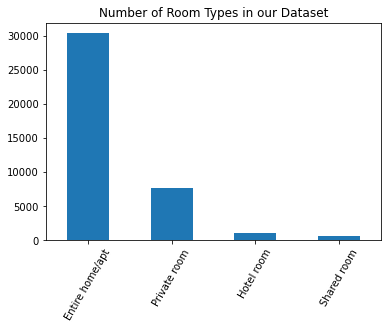

In [141]:
df6['room_type'].value_counts().plot(kind='bar', rot=60, title="Number of Room Types in our Dataset");

Let's now create some conditions and use `.where()` again to fill in the missing values.

In [142]:
condition_eh = (df6['cleaning_fee'].isna()) & (df6['room_type'] == 'Entire home/apt')
condition_hr = (df6['cleaning_fee'].isna()) & (df6['room_type'] == 'Hotel room')
condition_pr = (df6['cleaning_fee'].isna()) & (df6['room_type'] == 'Private room')
condition_sh = (df6['cleaning_fee'].isna()) & (df6['room_type'] == 'Shared room')

cleaning_fee = (df6['cleaning_fee'].where(~condition_eh, entire_home)
                                   .where(~condition_hr, hotel_room)
                                   .where(~condition_pr, private_room)
                                   .where(~condition_sh, shared_room))

df7 = df6.drop('cleaning_fee', axis=1).assign(cleaning_fee=cleaning_fee)

The code above is equivalent to creating a chain of lazy variables that build the operation we want one step at a time. Here is an example of another implementation.

```python
cleaning_fee1 = df6['cleaning_fee'].where(~condition_eh, entire_home)
cleaning_fee2 = cleaning_fee1.where(~condition_hr, hotel_room)
cleaning_fee3 = cleaning_fee2.where(~condition_pr, private_room)
cleaning_fee4 = cleaning_fee3.where(~condition_sh, shared_room)

df7 = df6.drop('cleaning_fee', axis=1).assign(cleaning_fee=cleaning_fee)
```

In [143]:
%%time

missing_values = df7.isna().sum()
whats_left_pct = (missing_values / df7.index.size) * 100
whats_left_pct

Wall time: 116 ms


id                                              0.0
listing_url                                     0.0
scrape_id                                       0.0
last_scraped                                    0.0
name                                            0.0
summary                                         0.0
space                                           0.0
description                                     0.0
experiences_offered                             0.0
neighborhood_overview                           0.0
notes                                           0.0
transit                                         0.0
access                                          0.0
interaction                                     0.0
house_rules                                     0.0
picture_url                                     0.0
host_id                                         0.0
host_url                                        0.0
host_name                                       0.0
host_since  

## 4. Saving Our Cleaned Dataset

Awesome Work!! We now have a clean dataset to work with.

In [144]:
df7.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_is_superhost,host_thumbnail_url,host_picture_url,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,is_location_exact,property_type,room_type,bed_type,amenities,minimum_nights,maximum_nights,calendar_updated,has_availability,calendar_last_scraped,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,first_review,last_review,latitude,longitude,bathrooms,price,extra_people,minimum_nights_avg_ntm,maximum_nights_avg_ntm,accommodates,guests_included,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,calculated_host_listings_count,calculated_host_listings_count_entire_homes,bedrooms,beds,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_listings_count,host_total_listings_count,security_deposit,review_scores_communication,review_scores_checkin,review_scores_location,review_scores_value,review_scores_cleanliness,review_scores_accuracy,reviews_per_month,host_acceptance_rate,host_response_rate,review_scores_rating,cleaning_fee
5866,31000095,https://www.airbnb.com/rooms/31000095,20200625032351,2020-06-26,Shinjuku JR Shin-okubo sta. 3mins Homely House,"The district Shinjuku area,nearby JR Shin-okub...","Three-storey building, four rooms: The first f...","The district Shinjuku area,nearby JR Shin-okub...",none,Shin-Okubo Station is famous for its Korean ci...,Basically check in time at 16:00 / check out t...,"◎ There are two nearest stations, namely Shin-...","The new decoration and equipment, we hope you ...",Any problem in Tokyo can provide assistance du...,Unknown,https://a0.muscache.com/im/pictures/92e9a30d-a...,23641660,https://www.airbnb.com/users/show/23641660,Airi,2014-11-12,"Toshima, Tokyo, Japan",Unknown,within an hour,f,https://a0.muscache.com/im/users/23641660/prof...,https://a0.muscache.com/im/users/23641660/prof...,"['email', 'phone', 'jumio', 'selfie', 'governm...",t,f,"Shinjuku, Tokyo, Japan",Shinjuku Ku,Shinjuku,Tokyo,169-0073,Tokyo,"Shinjuku, Japan",JP,Japan,t,House,Entire home/apt,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,Wa...",2,1125,3 months ago,t,2020-06-26,t,t,f,flexible,f,f,2019-02-26,2020-03-11,35.699100,139.697937,2.0,605.049622,20.582399,2.0,1125.0,11,2,2,2,1125,1125,26,46,63,149,19,13,2,2,4,7,0,0,12,12,205.795197,9.0,9.0,10.0,9.0,9.0,10.0,1.17,100.0,100.0,91.0,82.320000
13341,42388049,https://www.airbnb.com/rooms/42388049,20200625032351,2020-06-26,MUMU) Tokyo's premier center Shinjuku! Free WIFI,** Discount for May&June! ** Duplex Apartment ...,It is located a 7-minute walk from Higashi-Shi...,** Discount for May&June! ** Duplex Apartment ...,none,The best thing of my place is the accessibilit...,EASY Check-in and Checkout: Happy to be flexib...,Higashi Shinjuku station - 7mins on foot. JR S...,You will have full kitchen with everything you...,I am more than willing to help you out if you ...,Unknown,https://a0.muscache.com/im/pictures/c5606851-1...,30451776,https://www.airbnb.com/users/show/30451776,Emily,2015-04-02,Tokyo、日本,"Hello, guys! My name is Emily. \r\nI love to t...",within an hour,f,https://a0.muscache.com/im/pictures/user/6ab9c...,https://a0.muscache.com/im/pictures/user/6ab9c...,"['email', 'phone', 'manual_offline', 'offline_...",t,f,"Shinjuku City, Tōkyō-to, Japan",Shinjuku Ku,Shinjuku City,Tōkyō-to,160-0022,Tokyo,"Shinjuku City, Japan",JP,Japan,t,House,Entire home/apt,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,Wa...",1,1125,3 months ago,t,2020-

In [145]:
df7.dtypes

id                                               object
listing_url                                      object
scrape_id                                        object
last_scraped                                     object
name                                             object
summary                                          object
space                                            object
description                                      object
experiences_offered                              object
neighborhood_overview                            object
notes                                            object
transit                                          object
access                                           object
interaction                                      object
house_rules                                      object
picture_url                                      object
host_id                                          object
host_url                                        

In [146]:
cleaned_csv = check_or_add(path, 'clean_csv')
cleaned_parquet = check_or_add(path, 'clean_parquet')

In [147]:
df7.to_csv(os.path.join(cleaned_csv, 'clean_airbnb.csv'), index=False)

Parquet is a columnar data format that is faster and more efficient than comma separated values.

In [148]:
!pip install pyarrow fastparquet

  Running setup.py clean for fastparquet
  Created wheel for thrift: filename=thrift-0.13.0-py3-none-any.whl size=155595 sha256=a0cef7c487bb199636649e4284ad0e653716d7795f58888b91d001913e363801
  Stored in directory: c:\users\rick\appdata\local\pip\cache\wheels\0a\52\7e\8054b57725b8f2b9ddbaacb81b271b939681cc03f8231e6ebc
Successfully built thrift
Failed to build fastparquet
    Running setup.py install for fastparquet: started
    Running setup.py install for fastparquet: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\Rick\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Rick\\AppData\\Local\\Temp\\pip-install-9bu1mbed\\fastparquet\\setup.py'"'"'; __file__='"'"'C:\\Users\\Rick\\AppData\\Local\\Temp\\pip-install-9bu1mbed\\fastparquet\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Rick\AppData\Local\Temp\pip-wheel-hce8tv0u'
       cwd: C:\Users\Rick\AppData\Local\Temp\pip-install-9bu1mbed\fastparquet\
  Complete output (64 lines):
  Compiling fastparquet/speedups.pyx because it depends on C:\Users\Rick\anaconda3\lib\site-packages\Cython\Includes\numpy\__init__.pxd.
  [1/1] Cythonizing fastparquet/speedups.pyx
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.8
  creating build\lib.

In [149]:
df7.to_parquet(os.path.join(cleaned_parquet, 'clean_airbnb.parquet'), compression='snappy')

## Summary

Let's reacap what we have done now that we have a clean dataset.

1. Identify duplicates
2. Remove some missing values
3. Clean numerical variables
4. Recode numerical variables
5. Fill in missing values

### Blind Spots

- Vars representing currency and other numerical var could have gotten cleaned all together
- We could have dive deeper into the vars with less than 5% of missing values
- Dropping old columns and assigning new ones can happen in the same operation as opposed to in 2
- The removal of duplicates wasn't all that perfect. A better apprach would have been to create a custom column that given some criteria (e.g. a more clever combination of columns), identifies and removes the second identical instance of a column.